In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    PowerTransformer,
    QuantileTransformer,
    StandardScaler
)
from sklearn.pipeline import make_pipeline

PROJECT_ROOT = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(PROJECT_ROOT, "data")
NOTEBOOKS_PATH = os.path.join(PROJECT_ROOT, "notebooks")

## Load Dataset

In [2]:

red_wines = pd.read_csv(
    os.path.join(DATA_PATH, "winequality-red.csv"),
    delimiter=';'
)
red_wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Clean Dataset

Check for null values:

In [3]:
red_wines.info()  # no null values, all data types numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Check for duplicates -> remove duplicates because most of them occur in overrepresented classes

In [4]:
# Remove duplicates and check how many per class

vals_per_class = red_wines['quality'].value_counts()
red_wines.drop_duplicates(inplace=True)
new_vals_per_class = red_wines['quality'].value_counts()

print(vals_per_class - new_vals_per_class)

quality
5    104
6    103
7     32
4      0
8      1
3      0
Name: count, dtype: int64


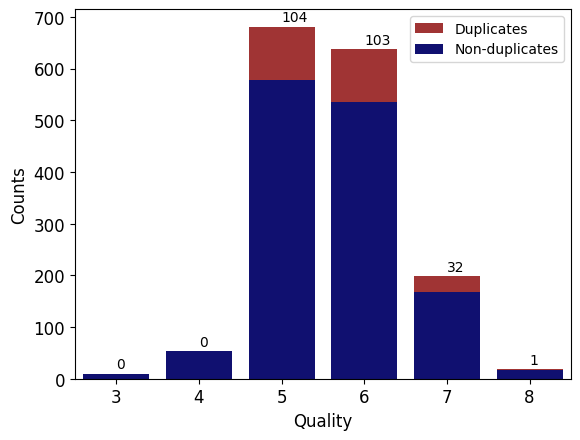

In [5]:
# Visualize the number of duplicates removed per class

fig, ax = plt.subplots()

ax = sns.barplot(
    vals_per_class,
    ax=ax,
    color='firebrick',
    label='Duplicates')

ax = sns.barplot(
    new_vals_per_class,
    ax=ax,
    color='navy',
    label='Non-duplicates'
)

for i in range(len(vals_per_class.index)):
    ax.text(
        vals_per_class.index[i]-3,
        vals_per_class.values[i]+10,
        str(vals_per_class.values[i] - new_vals_per_class.values[i]))

ax.legend(fontsize=10)
ax.tick_params(labelsize=12)
ax.set_xlabel('Quality', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
# fig.savefig('drop_duplicates.png', dpi=300)
plt.show()

## Stratified Train/Test Split

In [6]:
X = red_wines.iloc[:, :-1].to_numpy()  # features
y = red_wines.iloc[:, -1].to_numpy()  # target
feature_names = red_wines.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
# Save train and test splits as CSV files

np.savetxt(
    os.path.join(DATA_PATH, "y_train.csv"),
    y_train,
    delimiter=','
    )

np.savetxt(
    os.path.join(DATA_PATH, "X_test.csv"),
    X_test,
    delimiter=','
    )

np.savetxt(
    os.path.join(DATA_PATH, "y_test.csv"),
    y_test,
    delimiter=','
    )


## Exploratory Analysis on Training Data

In [8]:
# Prepare training data for visualization of feature distributions per class

red_wines_train = pd.DataFrame(
    np.hstack((X_train, y_train[:, None])),
    columns=feature_names
    )
df = pd.melt(
    red_wines_train,
    red_wines_train.columns[-1],
    red_wines_train.columns[:-1]
    )
df

,quality,variable,value
0,6.0,fixed acidity,7.2
1,6.0,fixed acidity,7.0
2,7.0,fixed acidity,8.5
3,5.0,fixed acidity,7.1
4,6.0,fixed acidity,7.1
...,...,...,...
11952,6.0,alcohol,9.5
11953,6.0,alcohol,10.9
11954,4.0,alcohol,12.0
11955,5.0,alcohol,10.6


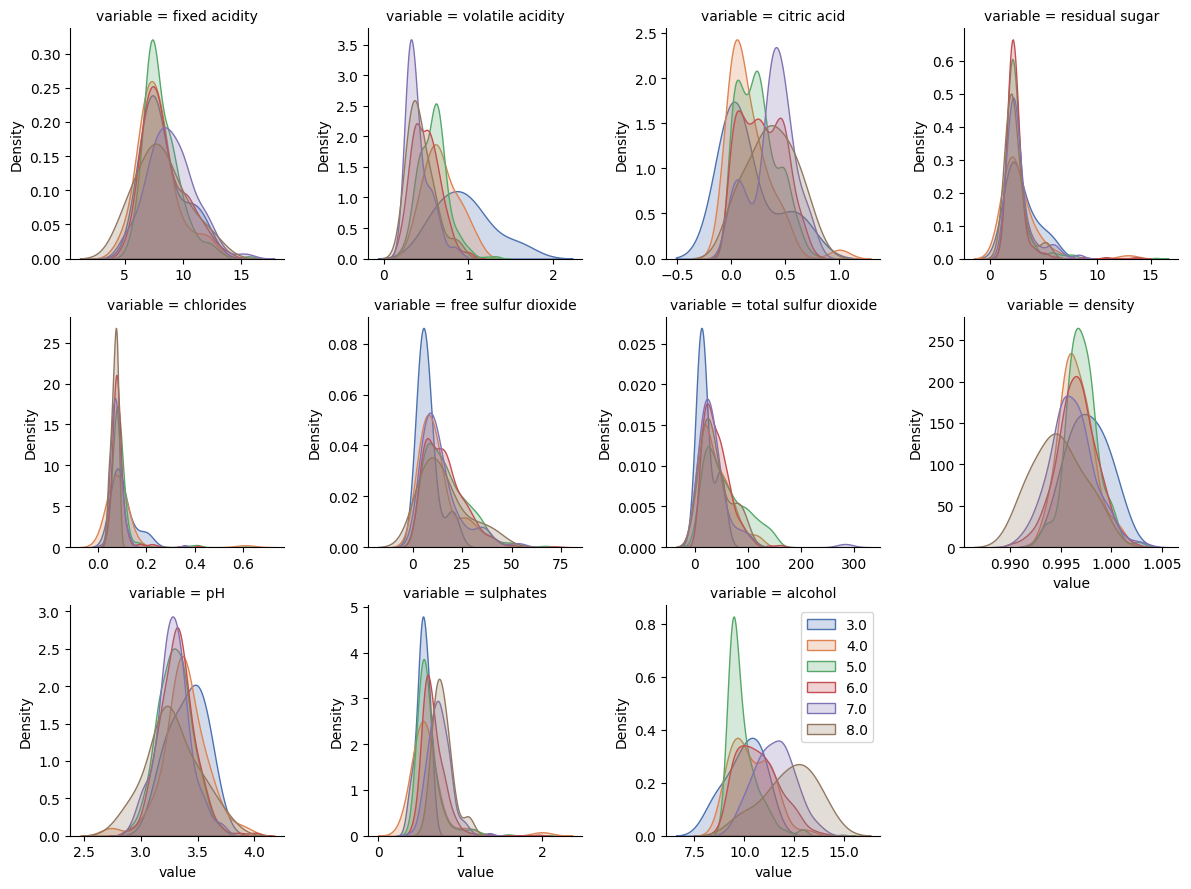

In [9]:
# Visualize feature distributions per class in training set

g = sns.FacetGrid(
    df,
    col="variable",
    hue="quality",
    col_wrap=4,
    sharex=False,
    sharey=False,
    palette="deep"
)
g.map(sns.kdeplot, "value", label='quality', fill=True)
plt.legend()
plt.show()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.250969,0.685317,0.108394,0.111620,-0.148797,-0.107580,0.681693,-0.692362,0.185657,-0.082233,0.119490
volatile acidity,-0.250969,1.000000,-0.541723,-0.016646,0.044609,-0.018540,0.085647,0.026928,0.262329,-0.265893,-0.192035,-0.397074
citric acid,0.685317,-0.541723,1.000000,0.160976,0.224507,-0.048059,0.050056,0.377045,-0.575572,0.318705,0.088379,0.243658
residual sugar,0.108394,-0.016646,0.160976,1.000000,0.030523,0.154960,0.219330,0.310850,-0.098451,-0.019525,0.057068,-0.014120
chlorides,0.111620,0.044609,0.224507,0.030523,1.000000,-0.006932,0.028299,0.213079,-0.269830,0.355370,-0.219222,-0.124486
free sulfur dioxide,-0.148797,-0.018540,-0.048059,0.154960,-0.006932,1.000000,0.673845,-0.043177,0.047378,0.045797,-0.066712,-0.032008
total sulfur dioxide,-0.107580,0.085647,0.050056,0.219330,0.028299,0.673845,1.000000,0.062850,-0.077101,0.013800,-0.201878,-0.165412
density,0.681693,0.026928,0.377045,0.310850,0.213079,-0.043177,0.062850,1.000000,-0.372488,0.140507,-0.514788,-0.184460
pH,-0.692362,0.262329,-0.575572,-0.098451,-0.269830,0.047378,-0.077101,-0.372488,1.000000,-0.195218,0.226500,-0.055011
sulphates,0.185657,-0.265893,0.318705,-0.019525,0.355370,0.045797,0.013800,0.140507,-0.195218,1.000000,0.101419,0.261085


<Axes: >

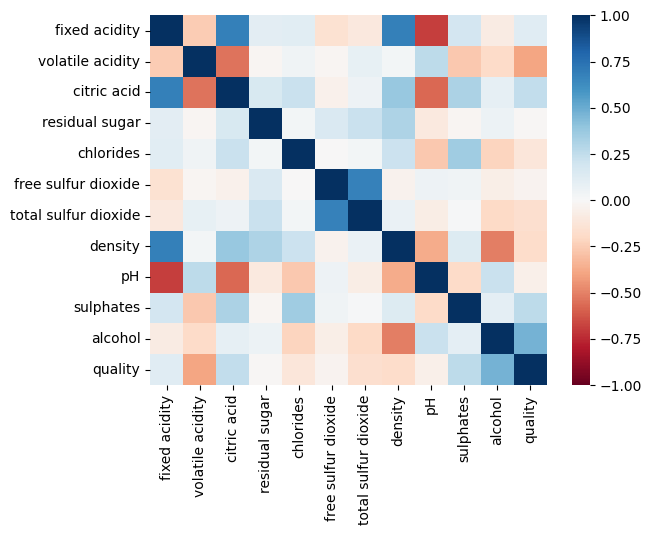

In [10]:
# Inspect correlations in training set

display(red_wines_train.corr())
sns.heatmap(red_wines_train.corr(), vmin=-1, vmax=1, cmap='RdBu')

In [11]:
# Summary statistics for features most correlated with quality

best_predictors = ['volatile acidity', 'sulphates', 'alcohol']

red_wines_train[best_predictors + ['quality']].describe()

,volatile acidity,sulphates,alcohol,quality
count,1087.000000,1087.000000,1087.000000,1087.000000
mean,0.532010,0.655989,10.443714,5.625575
std,0.185692,0.169598,1.096847,0.824693
min,0.160000,0.370000,8.400000,3.000000
25%,0.390000,0.550000,9.500000,5.000000
50%,0.520000,0.620000,10.200000,6.000000
75%,0.645000,0.720000,11.200000,6.000000
max,1.580000,2.000000,14.900000,8.000000


,volatile acidity,sulphates,alcohol,quality
volatile acidity,1.000000,-0.265893,-0.192035,-0.397074
sulphates,-0.265893,1.000000,0.101419,0.261085
alcohol,-0.192035,0.101419,1.000000,0.472495
quality,-0.397074,0.261085,0.472495,1.000000


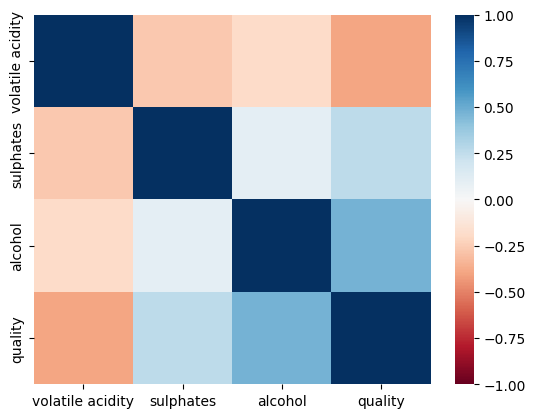

In [12]:
# Visualize correlations of features most correlated with quality

display(red_wines_train[best_predictors + ['quality']].corr())
sns.heatmap(
    red_wines_train[best_predictors + ['quality']].corr(),
    vmin=-1,
    vmax=1,
    cmap='RdBu'
    )
plt.show()

## Transform and Scale Training Data

In [13]:
# Select two scalers for inspection

p_scaler = PowerTransformer(
    method='yeo-johnson',
    standardize=True,
    copy=True
    )

q_scaler = QuantileTransformer(
    n_quantiles=100,
    output_distribution='normal',
    ignore_implicit_zeros=False,
    subsample=100,
    random_state=None,
    copy=True
)

# Transform training data
X_train_pscl = p_scaler.fit_transform(X_train)
X_train_qscl = q_scaler.fit_transform(X_train)


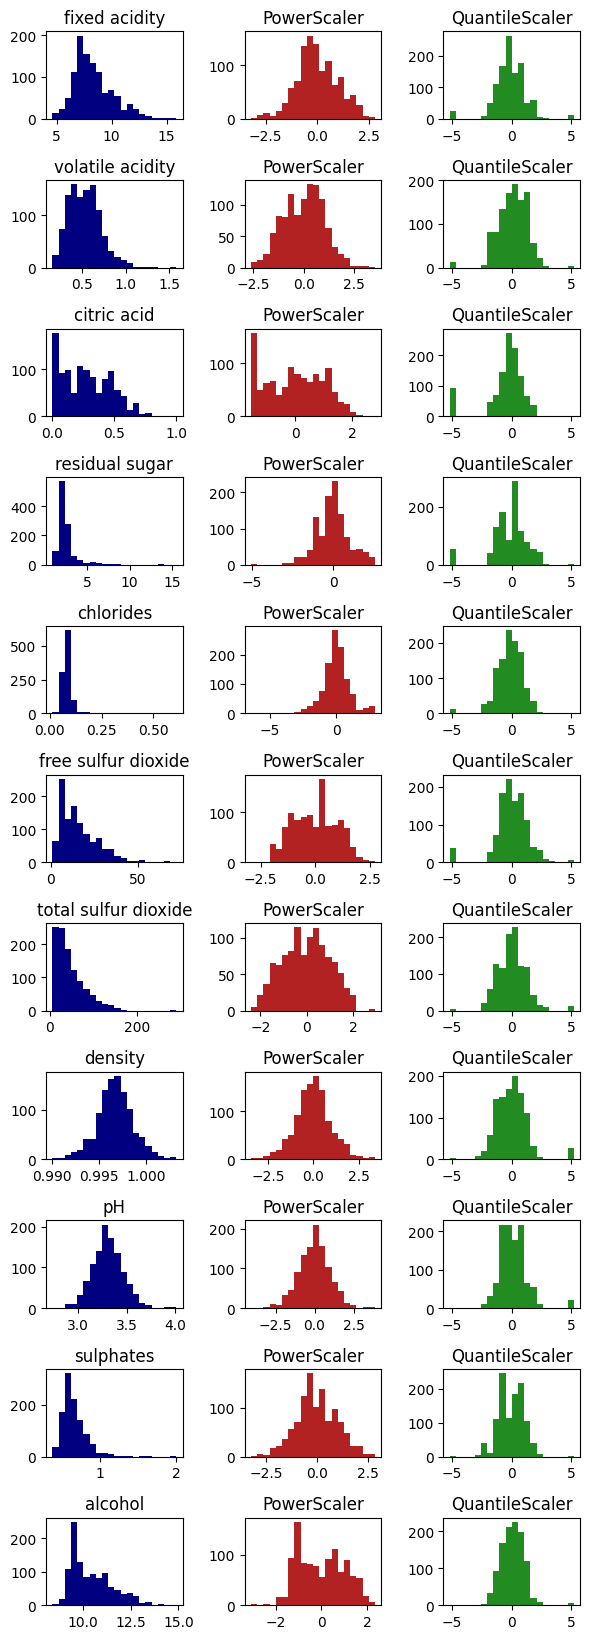

In [14]:
# Plot feature distributions for original and scaled training data

n_cols = 3
n_rows = 11

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*1.5))

for i in range(n_rows):
    ax[i, 0].hist(X_train[:, i], color='navy', bins=20)
    ax[i, 1].hist(X_train_pscl[:, i], color='firebrick', bins=20)
    ax[i, 2].hist(X_train_qscl[:, i], color='forestgreen', bins=20)

    ax[i, 0].set_title(feature_names[i])
    ax[i, 1].set_title('PowerScaler')
    ax[i, 2].set_title('QuantileScaler')

plt.tight_layout()
plt.show()

## Add Features

In [15]:
# Define a custom feature transformer that adds new features
# based on domain knowledge


class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialize any parameters you need here
        pass

    def fit(self, X, y=None):
        # Fit the transformer to the data
        # (e.g. compute any necessary statistics)
        return self

    def transform(self, X):
        # Create the custom features
        # Balance refers to the relationship between the four essential
        # elements of wine: tannin, acidity, alcohol and sugar.
        acids = X[:, :2].sum(axis=1)
        acids_per_sugar = acids / X[:, 3]
        acids_per_alc = acids / X[:, 10]
        alc_per_sugar = X[:, 10] / X[:, 3]
        sulf_per_sugar = X[:, 6] / X[:, 3]

        new_features = np.column_stack(
            (acids_per_sugar, acids_per_alc, alc_per_sugar, sulf_per_sugar)
            )

        X = np.hstack((X, new_features))

        return X

In [16]:
# Transform and Scale Training Data

cus_t = CustomFeatureTransformer()
X_new = cus_t.fit_transform(X_train_pscl)
# Give names to new features and create a DataFrame
new_cols = ['acid_sugar', 'acid_alc', 'alc_sugar', 'sulf_sugar']
X_new_pd = pd.DataFrame(
    np.hstack((X_new, y_train[:, None])),
    columns=list(red_wines.columns)[:-1] + new_cols + ['quality']
    )

X_new_pd.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,acid_sugar,acid_alc,alc_sugar,sulf_sugar,quality
0,-0.574851,-0.059771,-0.393342,-0.207084,-0.431257,-0.144121,-0.259607,0.469700,1.311666,0.673411,-0.774403,3.064558,0.819497,3.739558,1.253629,6.0
1,-0.723904,0.379412,0.143021,1.861921,0.270087,-0.144121,0.866704,-0.197711,0.106618,0.550551,0.715102,-0.185020,-0.481738,0.384067,0.465489,6.0
2,0.259700,-1.556486,1.378268,-0.862467,0.560826,1.521431,1.442894,0.099199,-0.019688,0.844295,0.281001,1.503578,-4.614880,-0.325811,-1.672985,7.0
3,-0.648581,0.054440,-1.328829,0.542601,-0.160553,0.703125,1.279744,0.386143,1.195705,-0.193161,-0.502651,-1.094988,1.182015,-0.926374,2.358537,5.0
4,-0.648581,0.532652,-1.397895,0.418014,0.087130,0.376721,1.199223,0.386143,1.078769,-0.193161,-0.635478,-0.277332,0.182427,-1.520232,2.868860,6.0


,acid_sugar,acid_alc,alc_sugar,sulf_sugar,quality
acid_sugar,1.000000,0.142793,-0.424695,-0.083979,0.081463
acid_alc,0.142793,1.000000,0.005735,-0.019472,0.038816
alc_sugar,-0.424695,0.005735,1.000000,-0.157332,-0.113203
sulf_sugar,-0.083979,-0.019472,-0.157332,1.000000,0.005909
quality,0.081463,0.038816,-0.113203,0.005909,1.000000


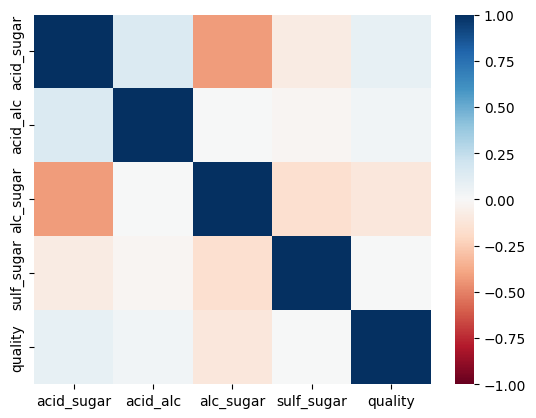

In [17]:
# Check correlations of new features with quality => low correlations :(

display(X_new_pd[new_cols + ['quality']].corr())
sns.heatmap(
    X_new_pd[new_cols + ['quality']].corr(),
    vmin=-1,
    vmax=1,
    cmap='RdBu'
)
plt.show()

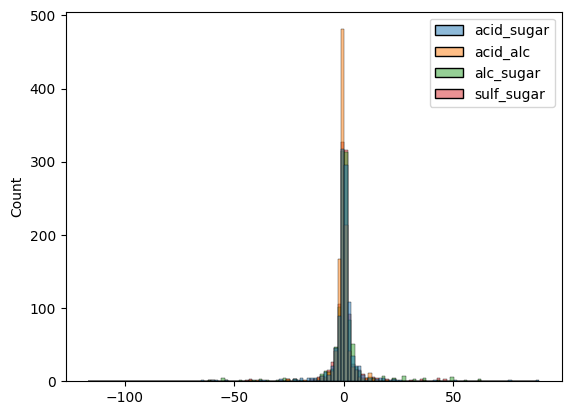

In [18]:
# Check distiributions of new features

sns.histplot(X_new_pd[new_cols])
plt.show()

## Build Preprocessing Pipeline and Save Preprocessed Data

In [19]:
preprocessing_pipe = make_pipeline(
    PowerTransformer(method='yeo-johnson', standardize=True, copy=True),
    CustomFeatureTransformer(),
    StandardScaler()
    )

In [20]:
# Transform and Scale Training Data

X_train_processed = preprocessing_pipe.fit_transform(X_train)
pd.DataFrame(
    X_train_processed,
    columns=list(red_wines.columns)[:-1] + new_cols
).head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,acid_sugar,acid_alc,alc_sugar,sulf_sugar
0,-0.574851,-0.059771,-0.393342,-0.207084,-0.431257,-0.144121,-0.259607,0.469700,1.311666,0.673411,-0.774403,0.243996,0.209428,0.330054,0.107147
1,-0.723904,0.379412,0.143021,1.861921,0.270087,-0.144121,0.866704,-0.197711,0.106618,0.550551,0.715102,-0.030574,0.046668,0.003817,0.026174
2,0.259700,-1.556486,1.378268,-0.862467,0.560826,1.521431,1.442894,0.099199,-0.019688,0.844295,0.281001,0.112102,-0.470310,-0.065200,-0.193530
3,-0.648581,0.054440,-1.328829,0.542601,-0.160553,0.703125,1.279744,0.386143,1.195705,-0.193161,-0.502651,-0.107461,0.254772,-0.123590,0.220664
4,-0.648581,0.532652,-1.397895,0.418014,0.087130,0.376721,1.199223,0.386143,1.078769,-0.193161,-0.635478,-0.038374,0.129743,-0.181328,0.273094


In [21]:
# Save transformed X_train as csv
CSV_PATH = os.path.join(DATA_PATH, "X_train_processed.csv")

np.savetxt(
    CSV_PATH,
    X_train_processed,
    delimiter=','
    )

In [ ]:
# Save preprocessing pipeline object as pickle
'''
PIPE_PATH = os.path.join(NOTEBOOKS_PATH, "preprocessing_pipeline.pkl")

with open(PIPE_PATH, 'wb') as p_file:
    pickle.dump(preprocessing_pipe, p_file)
'''